# Tiny Machine Learning on IoT devices

## 1. What is Ardunio

[Arduino](https://www.arduino.cc/) is an open-source hardware and software company, project, and user community that designs and manufactures single-board microcontrollers and microcontroller kits for building digital devices [1]. 

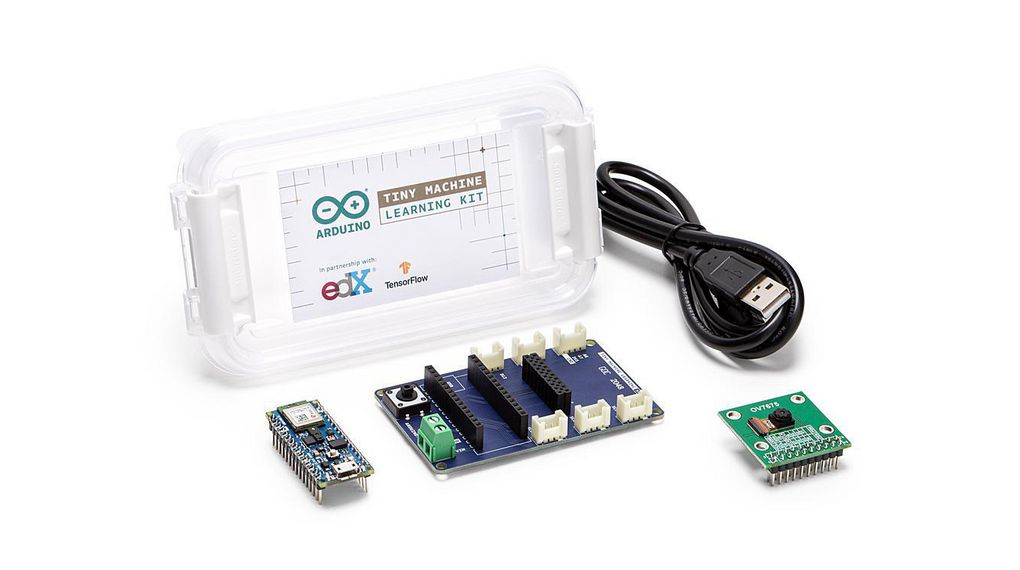

In our project, we use the ARDUNIO Nano 33 BLE Sense (**256 KB SRAM, 1MB flash**) from the ARDUNIO Tiny Machine Learning Kit.


What you need for this lab:

- An Arduino Nano 33 BLE Sense board
- A Micro USB cable to connect the Arduino board to your desktop machine
- To program your board, we recommend the ARDUINO IDE.
- Also, you can try the Web [IDE](https://create.arduino.cc/editor) with limited compilation times.
- If you have problems connecting your board to the Web IDE, please refer to this [solution](https://create.arduino.cc/getting-started/plugin/welcome).

## 2. The Fully-Connected Example



Here, we focus on the seizure detection using e-Glass [2], which you have seen in the previous labs. We use the [CHB-MIT](https://physionet.org/content/chbmit/1.0.0/) data as the dataset. Here, we go through an example based on fully-connected models.


### 2.1 Load the required module

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


- `numpy` is the high efficient library for array and matrix.
- `tensorflow` is the deep learning library.
- `sklearn` is the machine learning library and here we use `train_test_split` to split the dataset into traning and testing set randomly.

### 2.2 Load the data

Then, we load the EEG data `x` and we also load the category `y`.

In [ ]:
x = np.load('../input/machine-learning-for-iot-2023-lab-3/EEG.npy') #use the correct path of different year's course
y = np.load('../input/machine-learning-for-iot-2023-lab-3/Category.npy') #use the correct path of different year's course

### 2.3 Data split and normalization

We call `train_test_split` to split the original dataset into training set (60%), validation set (20%) and test set (20%).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

To balance the distribution among different channels, it's recommended to normalize the set. To avoid the problem of data snooping, we only consider the training set to calculate the mean and var.

In [ ]:
var_x = np.var(x_train, axis=0)
mean_x = np.mean(x_train, axis=0)
x_train = (x_train - np.reshape(mean_x, [1, -1])) / np.sqrt(np.reshape(var_x, [1, -1]))
x_val = (x_val - np.reshape(mean_x, [1, -1])) / np.sqrt(np.reshape(var_x, [1, -1]))
x_test = (x_test - np.reshape(mean_x, [1, -1])) / np.sqrt(np.reshape(var_x, [1, -1]))

window = 1024

x_train = np.reshape(x_train, (np.shape(x_train)[0], window))
x_val = np.reshape(x_val, (np.shape(x_val)[0], window))
x_test = np.reshape(x_test, (np.shape(x_test)[0], window))

### 2.4 Build the model

We construct the fully-connected model using Keras as follows.

In [ ]:
modelNN = tf.keras.models.Sequential([

            tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L1(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax)

                ])

modelNN.compile(optimizer='sgd', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

### 2.5 Train and test the model

In [ ]:
#  train the model

history = modelNN.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=40)

score = modelNN.evaluate(x_test, y_test, verbose=0)
print('The accuracy is ' + str(score[1]))

# save the model
modelNN.save('./model.h5')

### 2.6 Visualize the model

You can use online [netron](https://netron.app/) to visualize the .h5 model you saved.

## 3. Design the Tiny CNN for ARDUINO

We use [EloquentTinyML](https://www.arduino.cc/reference/en/libraries/eloquenttinyml/) , an Arduino library to make TensorFlow Lite for Microcontrollers Neural Networks more accessible and easy to use.



### 3.1 The simple 2D convolutional neural network

To successfully run the model in ARDUNIO Nano 33 BLE Sense (**256 KB SRAM, 1MB flash**) , we consider a simple 2D convolutional neural network here. Note: [TFLite](https://www.tensorflow.org/lite/microcontrollers/get_started_low_level) does not support Conv1D, Dropout and so on. [Please see the supported operations in TFLite Micro.](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/all_ops_resolver.cc)

In [ ]:
pip install tinymlgen

You should build up a simple 2D convolutional neural network considering its complexity and prediction performance. The goal of lab3 is to have a higher prediction performance while reducing the model complexity (which is measured in terms of running time on Arduino platform). We use [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) metric to evaluate your results. The evaluation is based on the following score:

$score = \frac{1}{80} \cdot \left \{   \sum_{i=0}^{40} (category_i-\overline{category}_i)^{2}+ \sum_{i=0}^{40} (time_i )^{2} \right \},$ 
where the $\overline{category}_i$ is the real category label of $i$ sample.

In [ ]:
from lib2to3.pytree import convert
import scipy.io
import numpy as np
import tensorflow as tf


from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tinymlgen import port


window = 1024

x = np.load('../input/machine-learning-for-iot-2023-lab-3/EEG.npy') #use the correct path of different year's course
y = np.load('../input/machine-learning-for-iot-2023-lab-3/Category.npy') #use the correct path of different year's course


#   data normalization  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4)

var_x = np.var(x_train, axis=0)
mean_x = np.mean(x_train, axis=0)
x_train = (x_train - np.reshape(mean_x, [1, -1])) / np.sqrt(np.reshape(var_x, [1, -1]))
x_val = (x_val - np.reshape(mean_x, [1, -1])) / np.sqrt(np.reshape(var_x, [1, -1]))
x_test = (x_test - np.reshape(mean_x, [1, -1])) / np.sqrt(np.reshape(var_x, [1, -1]))

print("Training shape", x_train.shape)
print("Validation shape", x_val.shape)
print("Test shape", x_test.shape)

# -------- construct your own Conv2D model----------------------#
x_train_reshaped = x_train.reshape(148,32,32,1)
x_val_reshaped = x_val.reshape(50,32,32,1)
x_test_reshaped = x_test.reshape(50,32,32,1)

print("Training reshape", x_train_reshaped.shape)
print("Validation reshape", x_val_reshaped.shape)
print("Test reshape", x_test_reshaped.shape)

modelNN = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(2,kernel_size=(2,1),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
    
])


# --------------------------------------------------------------#

modelNN.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy']) #from_logits=True

#  train the model
history = modelNN.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val), batch_size=8, epochs=50)
modelNN.summary()

score = modelNN.evaluate(x_test_reshaped, y_test, verbose=0)
print('The accuracy is ' + str(score[1]))

### 3.2 Model Transformation

To deploy the model to our Arduino Nano 33 BLE Sense, we should first convert the model into `net.h` file, including the information about layers and weights.

In [ ]:
c_code = port(modelNN, variable_name='seizure_model', pretty_print=True,optimize=False)
filename = 'net.h'
with open(filename,'w') as f: 
    f.write(c_code)

If you would like to visualize your model after transformation, you can use the following code (Optional). 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(modelNN)
converter.optimizations=[tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open('./modellite.tflite','wb').write(tflite_model)

## 4. Deploy the Tiny CNN on ARDUINO

We need three files in this project (All the three files should be in the same folder.):

- Arduino.ino: The main project file;
- `net.h`: you generate this file in Section 3.2 in this notebook;
- testdata.h: The test data includes 40 samples.

We should install the latest EloquentTinyML library if you use the Arduino IDE. But you do not need to do anything if you use the Arduino online editor, because that online editor has the EloquentTinyML library installed already.





Firstly, we include the necessary `net.h` and `testdata.h` files in Arduino.ino project. 

Then, we do the inference to get the classification results and calculate the inference time.

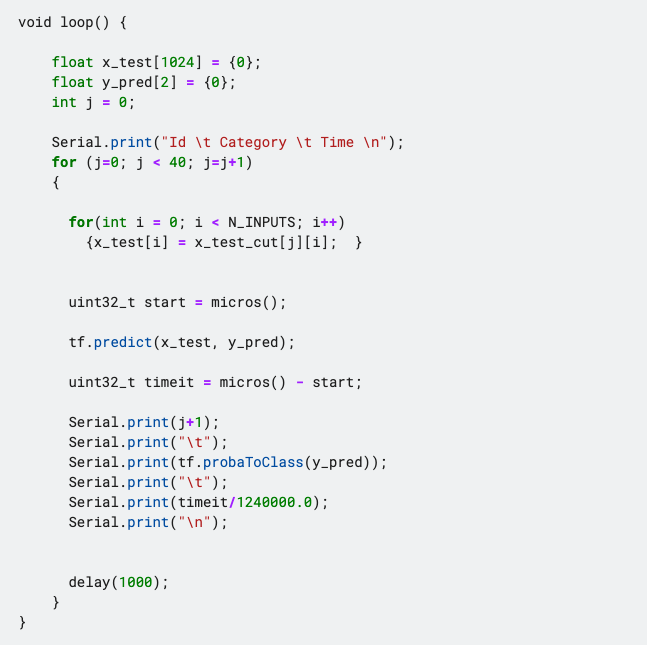

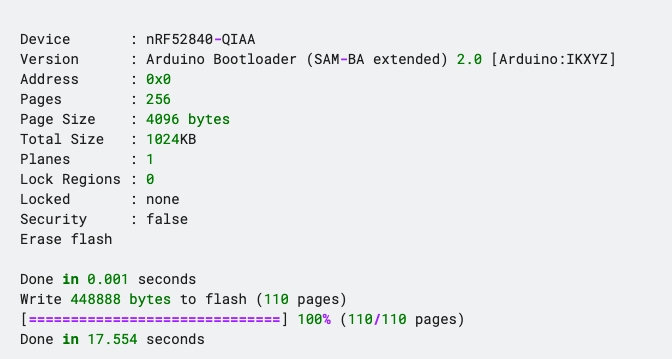Please upload the project to the board. 


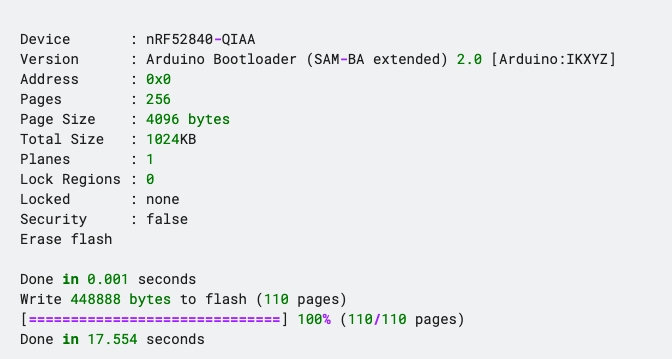

Next, please open the Tools->Serial Monitoring. If everything is OK, you will get the results in the format shown below (the actual values will be different for the 40 test samples).

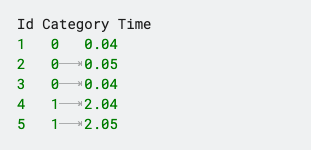

**Then you should copy the results to submission.csv and submit the submission.csv to the competition in Kaggle. You will pass this lab if your score on Kaggle is below 0.15. Please also make sure to submit your notebook and project files in .zip format on Canvas.**


## TENSORFLOW_ARENA_SIZE
We need to calculate the minimum necesarry memory allocated on the Arduino, "tensorflow_arena_size". The bottleneck is the largest forward pass of the model, which is from the last (and only) conolutional layer into the flatten layer. Any other layers can be discarded from RAM memory while these calculations are done. Weights are floating points.

- A floating point is 4 bytes = 32 bits.
- The convolution layer has an output of size (31 x 32 x 2). Lets calcualte room for (32 x 32 x 2) instead, to keep calculations as a power of 2. This results in 2048 floating points that must be kept in memory at the same time.
- When calculating the fowrard pass to the flatten, all results must also be kept in memory simultaneously. The flatten layer has the same size: another 2048 floating points.
 - A floating point is 4 bytes (32 bits). Thus we need 4x 4096 = 16,384 kb. Some RAM must be left for stability and for various other tasks. Through trial and error we found that 19Kb allocated memory was enough.



## 5. Common Problems: 



1. Please pay attention to the usage of Flash and SRAM. 

2. You can refer to [link1](https://docs.arduino.cc/learn/programming/memory-guide) [link2](https://www.seeedstudio.com/blog/2021/04/26/managing-arduino-memory-flash-sram-eeprom/) [link3](https://www.embeddedc.in/p/automotive-basics-part5.html) to understand the location of local variables, global variables, model weights and code on SRAM and Flash. 


3. TENSOR_ARENA_SIZE is an important variable should be tweaked based on your own model. You can refer to this [link](https://github.com/maarten-pennings/MachineLearning/blob/main/rock-paper-scissors/rock-paper-scissors.ipynb) to calculate the suitable TENSOR_ARENA_SIZE for your model. In principal, your biggest [activations](https://arxiv.org/abs/2007.11622) size of src+dst should be allocated by TENSOR_ARENA_SIZE.


4. If your outputs of Category and time in Serial Monitoring are all 0, please check the probability of two outputs using the code in Arduino.ino.

- If the probabilities of two outputs are 0. You can also use the code [Arduino.ino](https://www.kaggle.com/competitions/machine-learning-for-iot-lab3/data?select=Arduino.ino) to output the error message. Please check whether the layer you used is supported by TFLite or not. [The supported operations in TFLite Micro](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/all_ops_resolver.cc) 

- Then, please check the value of TENSOR_ARENA_SIZE. The reason could be that TENSOR_ARENA_SIZE is too small. But at the same time, SRAM will limit the maximum size of TENSOR_ARENA_SIZE. 



## Reference:


[1]: Wikipedia: https://en.wikipedia.org/wiki/Arduino

[2]: Sopic D, Aminifar A, Atienza D. e-glass: A wearable system for real-time detection of epileptic seizures[C]//2018 IEEE International Symposium on Circuits and Systems (ISCAS). IEEE, 2018: 1-5.